In [2]:
# Importing dependencies
%matplotlib inline  
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

In [3]:
# Loading data
data_dir = "../Data/"
frames = np.load(data_dir + "frames.npy")
controls = np.load(data_dir + "controls.npy")
speeds = np.load(data_dir + "speed.npy")

print("Frames:", frames.shape)
print("Controls:", controls.shape)
print("Speed:", speeds.shape)

Frames: (13926, 96, 96, 3)
Controls: (13926, 5)
Speed: (13926, 1)


In [4]:
assert frames.shape[0] == controls.shape[0] == speeds.shape[0]
num_frames = frames.shape[0]
num_pixels = frames.shape[1] * frames.shape[2] * 3

# Reshaping frames
frames = frames.reshape(num_frames, num_pixels)
print("Frames after reshaping:", frames.shape)

# Concatinating frames with controls and speed
data = np.hstack([frames, controls, speeds])
print("After concatination:", data.shape)

# Shuffling and Splitting
np.random.shuffle(data)
frames, controls, speeds = np.hsplit(data, np.array([num_pixels, num_pixels + 5]))

# Reshaping frames to original size
frames = frames.reshape(num_frames, 96, 96, 3)

print("Frames:", frames.shape)
print("Controls:", controls.shape)
print("Speed:", speeds.shape)

Frames after reshaping: (13926, 27648)
After concatination: (13926, 27654)
Frames: (13926, 96, 96, 3)
Controls: (13926, 5)
Speed: (13926, 1)


In [5]:
# Is gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [6]:
# Getting dataset ready
from torch.utils.data import Dataset

class CarRacingDataset(Dataset):

    def __init__(self, frames, controls, speeds, transform=None):
        self.frames = frames
        self.controls = controls
        self.speeds = speeds
        self.transform = transform

    def __len__(self):
        assert self.frames.shape[0] == self.controls.shape[0] == self.speeds.shape[0]
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        control = self.controls[idx]
        speed = self.speeds[idx]

        if self.transform:
            frame = self.transform(frame)/255
            control = self.transform(control.reshape(-1, 1))
            speed = self.transform(speed.reshape(-1, 1))

        return frame, control, speed

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


tensorize = transforms.Compose([transforms.ToTensor(),])

# 13926 samples with 66 batch_size => 211 batches => 150 train and 61 val
batch_size = 66
test_size = 61/211

train_frames, val_frames = train_test_split(frames, test_size=test_size, shuffle=False)
train_controls, val_controls = train_test_split(controls, test_size=test_size, shuffle=False)
train_speeds, val_speeds = train_test_split(speeds, test_size=test_size, shuffle=False)

train_set = CarRacingDataset(train_frames, train_controls, train_speeds, transform=tensorize)
val_set = CarRacingDataset(val_frames, val_controls, val_speeds, transform=tensorize)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=6)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=6)

In [8]:
f, c, s = iter(train_loader).next()
print(f.shape)
print(c.shape)
print(s.shape)

del frames, controls, speeds

torch.Size([66, 3, 96, 96])
torch.Size([66, 1, 5, 1])
torch.Size([66, 1, 1, 1])


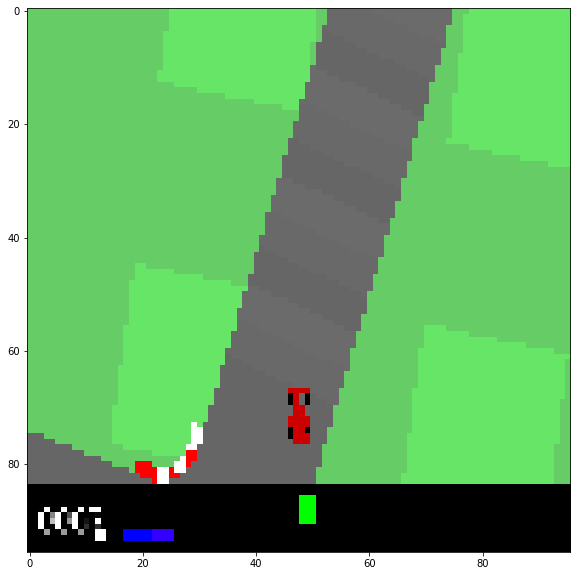

tensor([[[0.],
         [1.],
         [0.],
         [0.],
         [0.]]], dtype=torch.float64) tensor([[[2.]]], dtype=torch.float64)


In [9]:
# Frame, Control and Speed
img = f[20]
img = np.transpose(img, (1,2,0))
plt.gcf().set_size_inches(10, 10)
plt.imshow(img)
plt.show()
print(c[20], s[20])

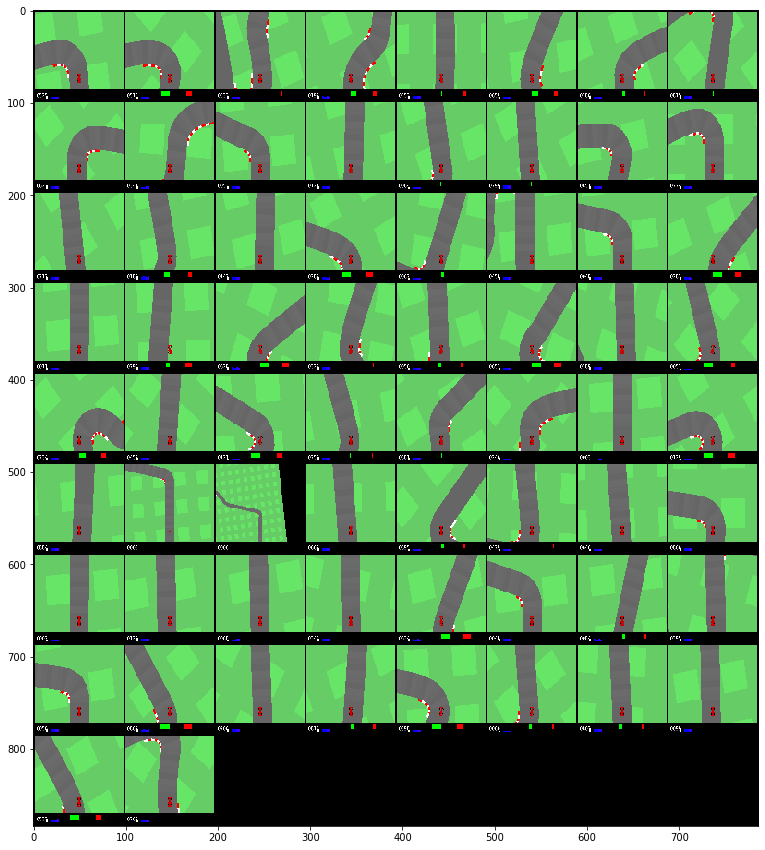

tensor([[[[1.],
          [0.],
          [0.],
          [0.],
          [0.]]],


        [[[1.],
          [0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.],
          [1.]]],


        [[[0.],
          [1.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.],
          [1.]]],


        [[[0.],
          [1.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [1.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [1.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [1.],
          [0.]]],


        [[[0.],
          [0.],
          [1.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [1.],
          [0.]]],


        [[[0.],
          [0.],
          [1.],
          [0.],
          [0

In [10]:
# A batch
def show_images(images):
    img = np.array(images.tolist())
    # making numpy compatible image
    img = np.transpose(img, (1,2,0))
    plt.gcf().set_size_inches(15, 15)
    plt.imshow(img)
    plt.show()
    
show_images(torchvision.utils.make_grid(f))
print(c)

In [11]:
# Plotting Loss and Accuracy
def plot_losses(stats):
    train_loss = stats["train_loss"]
    val_loss = stats["val_loss"]
    epochs = list(range(1, len(train_loss)+1))
    plt.plot(epochs, train_loss)
    plt.plot(epochs, val_loss)

In [12]:
# Defining model
import torch.nn as nn

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, 5, 2),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, 5, 2),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.BatchNorm2d(128)
                    )
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, 1),
                        nn.ReLU(),
                        nn.Conv2d(256, 512, 3, 1),
                        nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.BatchNorm2d(512)
                    )
        
        self.fc1 = nn.Sequential(
                        nn.Linear(512 * 3 * 3 + 1, 1024),
                        nn.ReLU(),
                        nn.BatchNorm1d(1024),
                        nn.Dropout(0.5)
                    )
        
        self.fc2 = nn.Sequential(
                        nn.Linear(1024, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(128),
                        nn.Dropout(0.5)
                    )
        
        self.out = nn.Sequential(
                        nn.Linear(128, 5),
                        nn.Softmax()
                    )

    def forward(self, x, y):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        xy = torch.cat((x, y), dim=1)
        xy = self.fc1(xy)
        xy = self.fc2(xy)
        xy = self.out(xy)
        return xy

In [13]:
# Initializing Network
model = Network()
model.to(device)
print(model)

Network(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4609, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1

In [14]:
# CovNet Output
from torchsummary import summary
summary(model, input_size=[(3, 96, 96), (1, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 46, 46]           4,864
              ReLU-2           [-1, 64, 46, 46]               0
            Conv2d-3          [-1, 128, 21, 21]         204,928
              ReLU-4          [-1, 128, 21, 21]               0
         MaxPool2d-5          [-1, 128, 10, 10]               0
       BatchNorm2d-6          [-1, 128, 10, 10]             256
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 6, 6]       1,180,160
             ReLU-10            [-1, 512, 6, 6]               0
        MaxPool2d-11            [-1, 512, 3, 3]               0
      BatchNorm2d-12            [-1, 512, 3, 3]           1,024
           Linear-13                 [-1, 1024]       4,720,640
             ReLU-14                 [-

/home/piyush/.conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [15]:
# Loss and Optimizer
from torch.optim import Adam

learning_rate = 0.003
Loss = nn.CrossEntropyLoss().to(device)
optim = Adam(model.parameters(), lr=learning_rate)

Epoch 1: train_loss: 1.2682342847188315 val_loss: 1.2477365380427876
Epoch 2: train_loss: 1.2358614738782248 val_loss: 1.202744843529873
Epoch 3: train_loss: 1.1877939756711324 val_loss: 1.190583019960122
Epoch 4: train_loss: 1.1713096125920615 val_loss: 1.1731934840561913
Epoch 5: train_loss: 1.1701102789243063 val_loss: 1.1936953927649827
Epoch 6: train_loss: 1.1627296980222066 val_loss: 1.1734319768968176
Epoch 7: train_loss: 1.1587074247996012 val_loss: 1.1581567428151116
Epoch 8: train_loss: 1.15412868420283 val_loss: 1.1519382312649586
Epoch 9: train_loss: 1.1463560350735982 val_loss: 1.150413655843891
Epoch 10: train_loss: 1.1380644392967225 val_loss: 1.1458913830460096


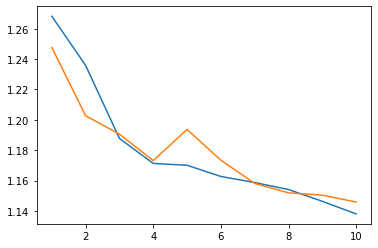

In [16]:
# Training the networks
import time
num_epochs = 10
num_batches_train = len(train_loader)
num_batches_val = len(val_loader)
stats = {"train_loss":[], "val_loss":[]}

for epoch in range(num_epochs):
    train_running_loss = 0
    val_running_loss = 0
    
    # Training the model
    for i, data in enumerate(train_loader):
        
        optim.zero_grad()
        
        frame, control, speed = data
        frame, control, speed = frame.to(device), control.to(device).view(batch_size, -1), speed.to(device)
        output = model(frame.float(), speed.float())

        loss = Loss(output, torch.argmax(control, dim=1))
        loss.backward()
        optim.step() 
        train_running_loss += loss.item()

    # Model validation
    for i, data in enumerate(val_loader):
        
        frame, control, speed = data
        frame, control, speed = frame.to(device), control.to(device).view(batch_size, -1), speed.to(device)
        output = model(frame.float(), speed.float())
        
        loss = Loss(output, torch.argmax(control, dim=1)).to(device)
        val_running_loss += loss.item()
    
    stats["train_loss"].append(train_running_loss/num_batches_train)
    stats["val_loss"].append(val_running_loss/num_batches_val)
    print("Epoch {}: train_loss: {} val_loss: {}".format(
        epoch + 1, stats["train_loss"][-1], stats["val_loss"][-1]))

plot_losses(stats)    

In [21]:
from gym.envs.box2d.car_racing import *
from extract_speed import get_speed


def get_control(out, absolute=False):
    
    if absolute:
        left = np.array([-1, 0, 0], dtype=np.float16)
        right = np.array([1, 0, 0], dtype=np.float16)
        up = np.array([0, 1, 0], dtype=np.float16)
        down = np.array([0, 0, 0.8], dtype=np.float16)
        no_key = np.array([0, 0, 0], dtype=np.float16)

        out = np.argmax(out)
        if out==0:
            return left
        elif out==1:
            return right
        elif out==2:
            return up
        elif out==3:
            return down
        return no_key
    
    control = np.array([0, 0, 0], dtype=np.float16)
    if out[0]>out[1]:
        control[0] = -out[0]
    else:
        control[0] = out[1]
    control[1] = out[2]
    control[2] = out[3]
    return control

scores = []
model = model.eval()
env = CarRacing()
for each_game in range(1):
    score = 0
    frame = env.reset()
    for i in range(1000):  
        env.render()
        
        speed = get_speed(frame)
        frame = np.transpose(frame, (2, 0, 1))/255
        frame = torch.tensor(frame).float().view(-1, 3, 96, 96).to(device)
        speed = torch.tensor(speed).float().view(-1, 1, 1, 1).to(device)
        
        out = model(frame, speed)
        out = out.squeeze().detach().cpu().numpy().astype(np.float16)
        frame, reward, done, info = env.step(get_control(out))
        
        score+=reward
        if done: 
            break
            
    scores.append(score)
    print('Episode {} Score: {}'.format(each_game+1,score))
    env.close()
    
print('Average Score:',sum(scores)/len(scores))

Track generation: 1231..1543 -> 312-tiles track
Episode 1 Score: -45.33762057877891
Average Score: -45.33762057877891
